### Data Preprocessing (taken from load_images.py)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import gc
from sklearn.model_selection import train_test_split

seed = 1234
np.random.seed(seed)

In [5]:
# Some intializations
# data_dir = '/content/drive/MyDrive/CS172B/'
data_dir = ''
train_path = data_dir + 'train'
test_path = data_dir + 'test'
affectNet_train_path =  data_dir + 'Affectnet_train' 
labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

def isNormalizedIMG(img):
    """Check whether the image has been normalized before"""
    for i in img:
        for j in i:
            for k in j:
                if k > 1: return False # has not been normalized
                if k < 1 and k > 0: return True # has been normalized
    return True

In [6]:
X = []; Y = []
X_test =[]; Y_test =[]
count = np.zeros((7))

# load FER2013 training dataset
for i in range(0,7):
    path = train_path+'/'+labels[i]
    for j in os.listdir(path):
        img = plt.imread(path+'/'+j) #load images
        RGB_img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) #convert to RGB
        if(isNormalizedIMG(RGB_img) == False): RGB_img = RGB_img/255 #if hasn't been normalized, normalize it
        X.append(RGB_img)
        Y.append(i)
        count[i]+=1
        
# load affectnet training dataset
for i in range(0,7):
    path = affectNet_train_path+'/'+labels[i]
    for j in os.listdir(path):
        img = plt.imread(path+'/'+j) #load images
        resized_img = cv2.resize(img,(48,48)) #resize to (48,48,3)
        if(isNormalizedIMG(resized_img) == False): resized_img = resized_img/255 #if hasn't been normalized, normalize it
        X.append(resized_img)
        Y.append(i)
        count[i]+=1

# load FER2013 testing dataset
for i in range(0,7):
    path = test_path+'/'+labels[i]
    for j in os.listdir(path):
        img = plt.imread(path+'/'+j) #load images
        RGB_img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) #convert to RGB
        if(isNormalizedIMG(RGB_img) == False): RGB_img = RGB_img/255 #If hasn't been normalized, normalize it
        X_test.append(RGB_img)
        Y_test.append(i)

In [7]:
# shuffle
X = np.array(X); Y = np.array(Y); X_test = np.array(X_test); Y_test = np.array(Y_test)
X_train,X_validation,Y_train,Y_validation = train_test_split(X,Y,test_size = 0.25, random_state = seed, shuffle = True, stratify = Y)

In [8]:
def getDataset():
    """Return np.arrays."""
    """Training set, Training set labels, Validation set, Validation set labels, Testing set, Testing set labels """
    return X_train, Y_train, X_validation, Y_validation, X_test, Y_test
    
def getDatasetCount():
    """Return count for each labels in the dataset"""
    return count

def getLabels():
    """Return labels in the dataset"""
    return labels

### Training & Testing Model

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import RandomUniform, Zeros, HeNormal, HeUniform

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, Reshape, GlobalAveragePooling2D, ZeroPadding2D, Cropping2D
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.utils import np_utils
from keras.optimizers import Adam, Adamax
from keras.regularizers import l2

import os
import visualkeras
from PIL import ImageFont

seed = 1234
np.random.seed(seed)

2023-06-11 13:29:42.786044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
X_train, Y_train, X_validation, Y_validation, X_test, Y_test = getDataset()

In [11]:
# Resnet Mandatory Preprocessing
X_train = preprocess_input(X_train)
X_validation = preprocess_input(X_validation)
X_test = preprocess_input(X_test)

In [12]:
print(f'X_train shape: {X_train.shape}')
print(f'X_validation shape: {X_validation.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (41160, 48, 48, 3)
X_validation shape: (13720, 48, 48, 3)
X_test shape: (7178, 48, 48, 3)


In [13]:
#####################################################################
###            ONE-RUN Hyperparameters to Be Tested               ###
#####################################################################
# hyperparameters
# Note: for optimizer, just write if statement or create simple function
#           to create the optimizer object based on str value
hyperparam_pooling = 'avg'
hyperparam_bias_init = RandomUniform(minval=-0.01, maxval=0.01, seed=seed)
hyperparam_lr = 0.008
hyperparam_optimizer = 'Adamax'
hyperparam_batch_size = 128
hyperparam_activation_function = 'relu'
hyperparam_bias_regularizer = 'l2'
hyperparam_dropout_rate = 0.4   # if using dropout layer(s)
hyperparam_loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
hyperparam_epoch = 100

hyperparameters = {
  # note: avg pooling returns a 2D tensor...idk wtf that is but probs need to resize somewhere
  'pooling': hyperparam_pooling,
  'bias_init': hyperparam_bias_init,
  'lr': hyperparam_lr,
  'optimizer': hyperparam_optimizer,
  'batch_size': hyperparam_batch_size,
  'activation_function': hyperparam_activation_function,
  'bias_regularizer': hyperparam_bias_regularizer,
  'dropout_rate': hyperparam_dropout_rate,
  'loss_function': hyperparam_loss_function,
  'epoch': hyperparam_epoch,
}

print(f'MODEL TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: ')
for key, value in hyperparameters.items():
  print(f'\t{key} value: {value}')


#####################################################################
###                    Load ResNet base_model                     ###
#####################################################################
base_model = ResNet50V2(include_top=False, 
                        weights='imagenet', 
                        input_shape=(48, 48, 3), 
                        pooling=hyperparam_pooling)

# freeze weights of base_model - note: this works because the 'trainable' attribute is recursive 
# (i.e. bc we freeze the base model, every layer in the model is frozen)
base_model.trainable = False
# for layer in base_model.layers:
#     layer.trainable = False


#####################################################################
###                         Create Model                          ###
#####################################################################
# trying kernel_size=(7, 7); worked kinda, overfitting now, training data saw increase but not validation
# trying kernel_size=(30, 30); same thing, overfitting, but better
# trying dropout_rate=0.4
# trying learning_rate = 0.005 (instead of 0.001); worked better kinda
# trying GlobalAveragePooling2D() (instead of MaxPool2D() + Dense()); didn't work as well
# trying learning_rate = 0.008 (instead of 0.005); didn't work better
model = keras.Sequential([
    base_model,
    # Flatten(),
    BatchNormalization(),
    Reshape(target_shape=(32, 32, 2)),
    Conv2D(64, kernel_size=(30, 30), activation=hyperparam_activation_function),
    Dropout(rate=0.4),
    # MaxPool2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Flatten(),
    # Dense(256, activation=hyperparam_activation_function),
    Dense(7, activation='softmax')
])


model.summary()
#####################################################################
###                        Compile Model                          ###
#####################################################################
model.compile(
    loss = hyperparam_loss_function, 
    optimizer= Adamax(learning_rate=hyperparam_lr) if hyperparam_optimizer == 'Adamax' else Adam(learning_rate=hyperparam_lr), 
    metrics=['accuracy']
)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'models/test', 
        save_freq = 'epoch',
        save_best_only = True
    )
]

#####################################################################
###                          Fit Model                            ###
#####################################################################
history = model.fit(
    X_train, Y_train, 
    validation_data=(X_validation, Y_validation),
    batch_size=hyperparam_batch_size, 
    epochs=hyperparam_epoch, 
    callbacks = callbacks
)


#####################################################################
###                    Plot Training Results                      ###
### Note: Modify code to store plots in a excel spreadsheet       ###
###         rather than plot.                                     ###
#####################################################################
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(range(hyperparam_epoch), acc, label='Training Accuracy', color='red')
plt.plot(range(hyperparam_epoch), val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(range(hyperparam_epoch), loss, label='Training Loss', color='red')
plt.plot(range(hyperparam_epoch), val_loss, label='Validation Loss', color='blue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#####################################################################
###              Best Model Prediction on Test Data               ###
### Note: write best model's prediction in new 'results.csv' file ###
#####################################################################
del(model)
model = load_model('models/test')
prediction = model.predict(X_test) # for each datapoint, gives a (1,7) vector contains probabilities

Y_prediction = np.argmax(prediction,axis = 1) # get the index(label) of highest probability for each 
prediction_accuracy = np.mean(Y_prediction==Y_test)
print(f"The accuracy on test data is: {prediction_accuracy*100:0.3f}%")

MODEL TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.RandomUniform object at 0x7faee7574790>
	lr value: 0.008
	optimizer value: Adamax
	batch_size value: 128
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7faee7474a00>
	epoch value: 100


2023-06-11 13:31:19.498215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 32, 32, 2)         0         
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 64)          115264    
                                                                 
 dropout (Dropout)           (None, 3, 3, 64)          0         
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                 

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 449s 1s/step - loss: 1.7701 - accuracy: 0.2940 - val_loss: 1.7779 - val_accuracy: 0.3093
Epoch 2/100
322/322 [==============================] - ETA: 0s - loss: 1.7033 - accuracy: 0.3291

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 349s 1s/step - loss: 1.7033 - accuracy: 0.3291 - val_loss: 1.6927 - val_accuracy: 0.3292
Epoch 3/100
322/322 [==============================] - ETA: 0s - loss: 1.6816 - accuracy: 0.3336

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 333s 1s/step - loss: 1.6816 - accuracy: 0.3336 - val_loss: 1.6675 - val_accuracy: 0.3473
Epoch 4/100
322/322 [==============================] - ETA: 0s - loss: 1.6640 - accuracy: 0.3452

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 343s 1s/step - loss: 1.6640 - accuracy: 0.3452 - val_loss: 1.6577 - val_accuracy: 0.3460
Epoch 5/100
322/322 [==============================] - ETA: 0s - loss: 1.6517 - accuracy: 0.3459

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 312s 969ms/step - loss: 1.6517 - accuracy: 0.3459 - val_loss: 1.6540 - val_accuracy: 0.3492
Epoch 6/100
322/322 [==============================] - ETA: 0s - loss: 1.6392 - accuracy: 0.3577

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 311s 967ms/step - loss: 1.6392 - accuracy: 0.3577 - val_loss: 1.6502 - val_accuracy: 0.3555
Epoch 7/100
322/322 [==============================] - ETA: 0s - loss: 1.6319 - accuracy: 0.3607

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 322s 1s/step - loss: 1.6319 - accuracy: 0.3607 - val_loss: 1.6474 - val_accuracy: 0.3482
Epoch 8/100
322/322 [==============================] - 288s 894ms/step - loss: 1.6247 - accuracy: 0.3608 - val_loss: 1.6565 - val_accuracy: 0.3512
Epoch 9/100
322/322 [==============================] - ETA: 0s - loss: 1.6186 - accuracy: 0.3643

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 312s 968ms/step - loss: 1.6186 - accuracy: 0.3643 - val_loss: 1.6377 - val_accuracy: 0.3582
Epoch 10/100
322/322 [==============================] - ETA: 0s - loss: 1.6107 - accuracy: 0.3675

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 317s 984ms/step - loss: 1.6107 - accuracy: 0.3675 - val_loss: 1.6273 - val_accuracy: 0.3580
Epoch 11/100
322/322 [==============================] - ETA: 0s - loss: 1.6065 - accuracy: 0.3683

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 330s 1s/step - loss: 1.6065 - accuracy: 0.3683 - val_loss: 1.6228 - val_accuracy: 0.3621
Epoch 12/100
322/322 [==============================] - 292s 907ms/step - loss: 1.5967 - accuracy: 0.3750 - val_loss: 1.6330 - val_accuracy: 0.3551
Epoch 13/100
322/322 [==============================] - ETA: 0s - loss: 1.5931 - accuracy: 0.3759

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


322/322 [==============================] - 329s 1s/step - loss: 1.5931 - accuracy: 0.3759 - val_loss: 1.6219 - val_accuracy: 0.3660
Epoch 14/100
322/322 [==============================] - ETA: 0s - loss: 1.5876 - accuracy: 0.3749

KeyboardInterrupt: 

In [ ]:
font = ImageFont.load_default()
visualkeras.layered_view(model, legend=True, font=font, to_file='visual.png')  # font is optional!

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 reshape_3 (Reshape)         (None, 32, 32, 2)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 64)        1216      
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 256)       295168    
                                                      

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 1059s 1s/step - loss: 1.6313 - accuracy: 0.3576 - val_loss: 1.6577 - val_accuracy: 0.3454
Epoch 2/10
673/673 [==============================] - ETA: 0s - loss: 1.6273 - accuracy: 0.3588

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 633s 940ms/step - loss: 1.6273 - accuracy: 0.3588 - val_loss: 1.6576 - val_accuracy: 0.3455
Epoch 3/10
673/673 [==============================] - ETA: 0s - loss: 1.6259 - accuracy: 0.3594

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 387s 575ms/step - loss: 1.6259 - accuracy: 0.3594 - val_loss: 1.6561 - val_accuracy: 0.3482
Epoch 4/10
673/673 [==============================] - ETA: 0s - loss: 1.6248 - accuracy: 0.3610

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 368s 547ms/step - loss: 1.6248 - accuracy: 0.3610 - val_loss: 1.6559 - val_accuracy: 0.3478
Epoch 5/10
673/673 [==============================] - ETA: 0s - loss: 1.6239 - accuracy: 0.3614

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 356s 529ms/step - loss: 1.6239 - accuracy: 0.3614 - val_loss: 1.6553 - val_accuracy: 0.3494
Epoch 6/10
673/673 [==============================] - ETA: 0s - loss: 1.6233 - accuracy: 0.3611

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 362s 538ms/step - loss: 1.6233 - accuracy: 0.3611 - val_loss: 1.6549 - val_accuracy: 0.3482
Epoch 7/10
673/673 [==============================] - ETA: 0s - loss: 1.6226 - accuracy: 0.3609

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 354s 526ms/step - loss: 1.6226 - accuracy: 0.3609 - val_loss: 1.6546 - val_accuracy: 0.3488
Epoch 8/10
673/673 [==============================] - ETA: 0s - loss: 1.6220 - accuracy: 0.3608

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 355s 527ms/step - loss: 1.6220 - accuracy: 0.3608 - val_loss: 1.6544 - val_accuracy: 0.3489
Epoch 9/10
673/673 [==============================] - ETA: 0s - loss: 1.6215 - accuracy: 0.3618

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 357s 530ms/step - loss: 1.6215 - accuracy: 0.3618 - val_loss: 1.6539 - val_accuracy: 0.3499
Epoch 10/10
673/673 [==============================] - 336s 500ms/step - loss: 1.6210 - accuracy: 0.3619 - val_loss: 1.6540 - val_accuracy: 0.3503


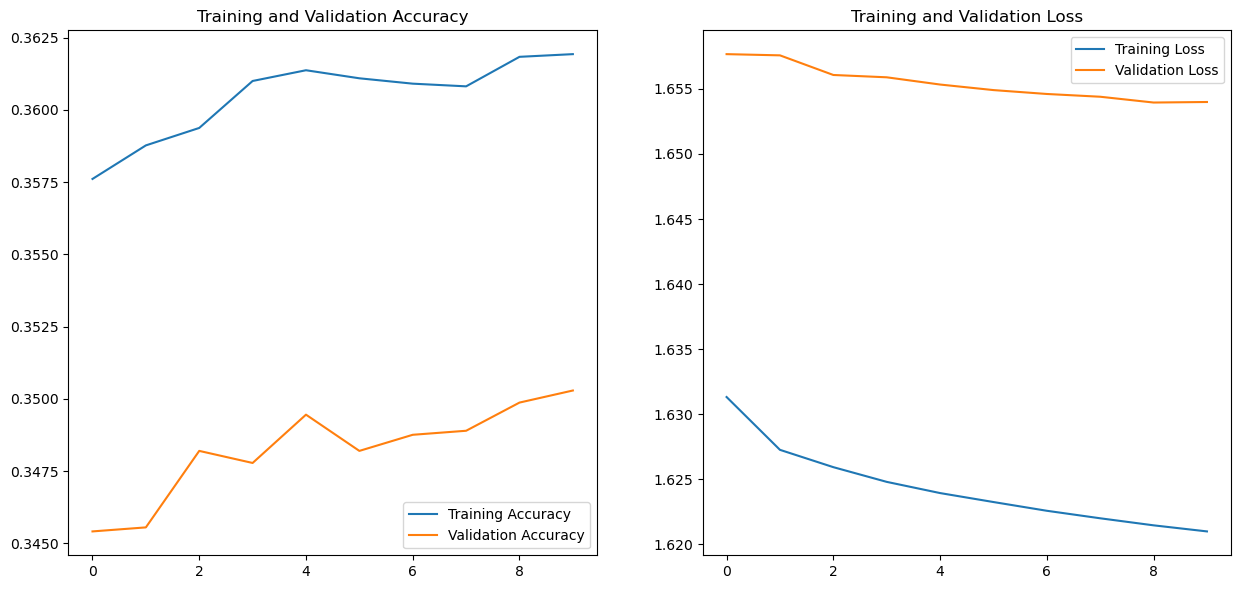

225/225 [==============================] - 56s 245ms/step
The accuracy on test data is: 35.093%


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    loss = hyperparam_loss_function, 
    optimizer= Adamax(learning_rate=1e-5) if hyperparam_optimizer == 'Adamax' else Adam(learning_rate=1e-5), 
    metrics=['accuracy']
)
model.summary()

#####################################################################
###                          Fit Model                            ###
#####################################################################
history = model.fit(
    X_train, Y_train, 
    validation_data=(X_validation, Y_validation),
    batch_size=hyperparam_batch_size, 
    epochs=hyperparam_epoch, 
    callbacks = callbacks
)


#####################################################################
###                    Plot Training Results                      ###
### Note: Modify code to store plots in a excel spreadsheet       ###
###         rather than plot.                                     ###
#####################################################################
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(range(hyperparam_epoch), acc, label='Training Accuracy', color='red')
plt.plot(range(hyperparam_epoch), val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(range(hyperparam_epoch), loss, label='Training Loss', color='red')
plt.plot(range(hyperparam_epoch), val_loss, label='Validation Loss', color='blue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#####################################################################
###              Best Model Prediction on Test Data               ###
### Note: write best model's prediction in new 'results.csv' file ###
#####################################################################
del(model)
model = load_model('models/test')
prediction = model.predict(X_test) # for each datapoint, gives a (1,7) vector contains probabilities

Y_prediction = np.argmax(prediction,axis = 1) # get the index(label) of highest probability for each 
prediction_accuracy = np.mean(Y_prediction==Y_test)
print(f"The accuracy on test data is: {prediction_accuracy*100:0.3f}%")

In [ ]:
visualkeras.layered_view(model, legend=True, font=font, to_file='visual_post_unfreeze.png')  # font is optional!

In [5]:
#####################################################################
###           MULTIPLE Hyperparameters to Be Tested               ###
#####################################################################
MODEL_NUMBER = 1
FILENAME = 'results.csv'
PATH_TO_DIR_CONTAINING_PLOTS = os.getcwd() + '/plots'
PATH_TO_FILE_CONTAINING_RESULTS = ''
I = 1
# Enter Model Integer to Start At
START_I = 4
# for google colab;
# FILENAME = '/content/drive/MyDrive/UCI/3_Junior/3_Spring_23/CS_172B/results.csv'
# PATH_TO_DIR_CONTAINING_PLOTS = '/content/drive/MyDrive/UCI/3_Junior/3_Spring_23/CS_172B'
# PATH_TO_FILE_CONTAINING_RESULTS = '/content/drive/MyDrive/UCI/3_Junior/3_Spring_23/CS_172B/'


# hyperparameters
# Note: for optimizer, just write if statement or create simple function
#           to create the optimizer object based on str value
hyperparam_pooling = ['avg', 'max']
hyperparam_bias_init = [RandomUniform(minval=-0.01, maxval=0.01, seed=seed),
                        Zeros(), HeNormal(seed=seed), HeUniform(seed=seed)]
hyperparam_lr = [0.001, 0.01, 0.1]
hyperparam_optimizer = ['Adam', 'Adamax']
hyperparam_batch_size = [16, 32, 64, 128, 256, 512]
hyperparam_activation_function = ['relu']
hyperparam_bias_regularizer = ['l2']
hyperparam_dropout_rate = [0.4, 0.3, 0.2]   # if using dropout layer(s)
hyperparam_loss_function = [tf.keras.losses.SparseCategoricalCrossentropy()]
hyperparam_epoch = [10, 25, 50, 100, 250]

hyperparameters = {
  # note: avg pooling returns a 2D tensor...idk wtf that is but probs need to resize somewhere
  'pooling': hyperparam_pooling,
  'bias_init': hyperparam_bias_init,
  'lr': hyperparam_lr,
  'optimizer': hyperparam_optimizer,
  'batch_size': hyperparam_batch_size,
  'activation_function': hyperparam_activation_function,
  'bias_regularizer': hyperparam_bias_regularizer,
  'dropout_rate': hyperparam_dropout_rate,
  'loss_function': hyperparam_loss_function,
  'epoch': hyperparam_epoch,
}

# CURRENT TESTING: want to test each hyperparameter 1 by 1 first,
#   so we set everything to default at the start of each run for now,
#   changing one hyperparamter at a time
# defaults
default_pooling = 'avg'
default_bias_init = RandomUniform(minval=-0.01, maxval=0.01, seed=seed)
default_lr = 0.01
default_optimizer = 'Adamax'
default_batch_size = 32
default_activation_function = 'relu'
default_bias_regularizer = 'l2'
default_dropout_rate = 0.4
default_loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
default_epoch = 10

defaults = {
    'pooling': default_pooling,
    'bias_init': default_bias_init,
    'lr': default_lr,
    'optimizer': default_optimizer,
    'batch_size': default_batch_size,
    'activation_function': default_activation_function,
    'bias_regularizer': default_bias_regularizer,
    'dropout_rate': default_dropout_rate,
    'loss_function': default_loss_function,
    'epoch': default_epoch,
}

if START_I == 1:
  # header for 'results.csv'
  with open(FILENAME, 'a') as f:
    f.write("Model No.,Pooling Type,Bias Init,Bias Regularizer,Optimizer,Activation Function,Loss Function,Dropout Rate,Learning Rate,Batch Size,Epoch,Train Accuracy,Validation Accuracy,Test Accuracy\n")


# FOR LOOP STARTS HERE, EVERY HYPERPARAMETER SHOULD BE A VARIABLE
for h_key, h_value in hyperparameters.items():
  for h_element in h_value:
    if I < START_I:
      I += 1
      MODEL_NUMBER += 1
      continue
    print(f'MODEL: {MODEL_NUMBER} TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: ')
    print(f'hyperparameter currently being tested: {h_key} [{h_element}]')

    # set hyperparameter values
    curr_pooling = defaults['pooling'] if h_key != 'pooling' else h_element
    curr_bias_init = defaults['bias_init'] if h_key != 'bias_init' else h_element
    curr_lr = defaults['lr'] if h_key != 'lr' else h_element
    # NOTE: optimizer is still a string here!
    curr_optimizer = defaults['optimizer'] if h_key != 'optimizer' else h_element
    curr_batch_size = defaults['batch_size'] if h_key != 'batch_size' else h_element
    curr_activation_function = defaults['activation_function'] if h_key != 'activation_function' else h_element
    curr_bias_regularizer = defaults['bias_regularizer'] if h_key != 'bias_regularizer' else h_element
    curr_dropout_rate = defaults['dropout_rate'] if h_key != 'dropout_rate' else h_element
    curr_loss_function = defaults['loss_function'] if h_key != 'loss_function' else h_element
    curr_epoch = defaults['epoch'] if h_key != 'epoch' else h_element

    current = [
      curr_pooling,
      curr_bias_init,
      curr_lr,
      curr_optimizer,
      curr_batch_size,
      curr_activation_function,
      curr_bias_regularizer,
      curr_dropout_rate,
      curr_loss_function,
      curr_epoch
    ]

    for i, key in enumerate(hyperparameters.keys()):
      print(f'\t{key} value: {current[i]}')


    #####################################################################
    ###                    Load ResNet base_model                     ###
    #####################################################################
    base_model = ResNet50V2(include_top=False, 
                            weights='imagenet', 
                            input_shape=(48, 48, 3), 
                            pooling=curr_pooling)

    # freeze weights of base_model - note: this works because the 'trainable' attribute is recursive 
    # (i.e. bc we freeze the base model, every layer in the model is frozen)
    base_model.trainable = False
    # for layer in base_model.layers:
    #     layer.trainable = False


    #####################################################################
    ###                         Create Model                          ###
    #####################################################################
    inputs = keras.Input(shape=(48, 48, 3))

    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning later
    x = base_model(
          inputs, 
          training=False
        )

    x = Dense(
          name='dense-1',
          units=2048, 
          activation=curr_activation_function, 
          use_bias=True, 
          bias_regularizer=curr_bias_regularizer, 
          bias_initializer=curr_bias_init
        )(x)
    x = Dense(
          name='dense-2',
          units=1024, 
          activation=curr_activation_function, 
          use_bias=True, 
          bias_regularizer=curr_bias_regularizer, 
          bias_initializer=curr_bias_init
        )(x)
    x = Dense(
          name='dense-3',
          units=512, 
          activation=curr_activation_function, 
          use_bias=True, 
          bias_regularizer=curr_bias_regularizer, 
          bias_initializer=curr_bias_init
        )(x)
    # prevent overfitting & improve the generalization performance of the model by randomly "dropping out" 
    #   (i.e., temporarily removing) a portion of the units or nodes in a layer during training
    x = Dropout(
          name='dropout',
          rate=curr_dropout_rate
        )(x)
    x = Dense(
          name='dense-4',
          units=256, 
          activation=curr_activation_function, 
          use_bias=True, 
          bias_regularizer=curr_bias_regularizer, 
          bias_initializer=curr_bias_init
        )(x)
    # only flatten if using conv2d lol...
    # x = Flatten()(x)
    outputs = Dense(
          name='dense_output', 
          units=7, 
          activation='softmax'
        )(x)

    model = Model(inputs, outputs)
    model.summary()


    #####################################################################
    ###                        Compile Model                          ###
    #####################################################################
    model.compile(
        loss = curr_loss_function, 
        optimizer= Adamax(learning_rate=curr_lr) if curr_optimizer == 'Adamax' else Adam(learning_rate=curr_lr), 
        metrics=['accuracy']
    )
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath = 'models/test', 
            save_freq = 'epoch',
            save_best_only = True
        )
    ]

    #####################################################################
    ###                          Fit Model                            ###
    #####################################################################
    history = model.fit(
        X_train, Y_train, 
        validation_data=(X_validation, Y_validation),
        batch_size=curr_batch_size, 
        epochs=curr_epoch, 
        callbacks = callbacks
    )


    #####################################################################
    ###                    Plot Training Results                      ###
    ### Note: Modify code to store plots in a excel spreadsheet       ###
    ###         rather than plot.                                     ###
    #####################################################################
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(range(curr_epoch), acc, label='Training Accuracy')
    plt.plot(range(curr_epoch), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.savefig(f"{PATH_TO_DIR_CONTAINING_PLOTS}/accuracy/training_validation_accuracy{MODEL_NUMBER}.png")
    plt.clf()

    plt.subplot(2, 2, 2)
    plt.plot(range(curr_epoch), loss, label='Training Loss')
    plt.plot(range(curr_epoch), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(f"{PATH_TO_DIR_CONTAINING_PLOTS}/loss/training_validation_loss{MODEL_NUMBER}.png")


    #####################################################################
    ###              Best Model Prediction on Test Data               ###
    ### Note: write best model's prediction in new 'results.csv' file ###
    #####################################################################
    del(model)
    model = load_model('models/test')
    prediction = model.predict(X_test) # for each datapoint, gives a (1,7) vector contains probabilities

    Y_prediction = np.argmax(prediction,axis = 1) # get the index(label) of highest probability for each 
    prediction_accuracy = np.mean(Y_prediction==Y_test)
    print(f"The accuracy on test data is: {prediction_accuracy*100:0.3f}%")

    with open(PATH_TO_FILE_CONTAINING_RESULTS + FILENAME, 'a') as f:
      f.write(str(MODEL_NUMBER) + ',' +
              str(curr_pooling) + ',' +
              str(curr_bias_init) + ',' +
              str(curr_bias_regularizer) + ',' +
              str(curr_optimizer) + ',' +
              str(curr_activation_function) + ',' +
              str(curr_loss_function) + ',' +
              str(curr_dropout_rate) + ',' +
              str(curr_lr) + ',' +
              str(curr_batch_size) + ',' +
              str(curr_epoch) + ',' +
              "{:.4f}".format(max(acc)) + ',' +
              "{:.4f}".format(max(val_acc)) + ',' +
              "{:.4f}".format(prediction_accuracy) + '\n')


    print('\n\n')
    MODEL_NUMBER += 1
# FOR LOOP ENDS HERE

MODEL: 4 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: bias_init [<keras.initializers.initializers_v2.Zeros object at 0x7f934f2048e0>]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.Zeros object at 0x7f934f2048e0>
	lr value: 0.01
	optimizer value: Adamax
	batch_size value: 32
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epoch value: 10


2023-06-04 01:38:59.995591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense-1 (Dense)             (None, 2048)              4196352   
                                                                 
 dense-2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense-3 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense-4 (Dense)             (None, 256)               131328

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 540s 767ms/step - loss: 1.9426 - accuracy: 0.2478 - val_loss: 1.8070 - val_accuracy: 0.2449
Epoch 2/10
673/673 [==============================] - ETA: 0s - loss: 1.7947 - accuracy: 0.2610

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 505s 751ms/step - loss: 1.7947 - accuracy: 0.2610 - val_loss: 1.7815 - val_accuracy: 0.2810
Epoch 3/10
673/673 [==============================] - ETA: 0s - loss: 1.7826 - accuracy: 0.2676

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 491s 730ms/step - loss: 1.7826 - accuracy: 0.2676 - val_loss: 1.7796 - val_accuracy: 0.2731
Epoch 4/10
673/673 [==============================] - ETA: 0s - loss: 1.7728 - accuracy: 0.2721

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 549s 816ms/step - loss: 1.7728 - accuracy: 0.2721 - val_loss: 1.7533 - val_accuracy: 0.2813
Epoch 5/10
673/673 [==============================] - ETA: 0s - loss: 1.7596 - accuracy: 0.2815

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 455s 675ms/step - loss: 1.7596 - accuracy: 0.2815 - val_loss: 1.7420 - val_accuracy: 0.2957
Epoch 6/10
673/673 [==============================] - 437s 650ms/step - loss: 1.7499 - accuracy: 0.2843 - val_loss: 1.7608 - val_accuracy: 0.2769
Epoch 7/10
673/673 [==============================] - ETA: 0s - loss: 1.7378 - accuracy: 0.2896

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 522s 776ms/step - loss: 1.7378 - accuracy: 0.2896 - val_loss: 1.7331 - val_accuracy: 0.2844
Epoch 8/10
673/673 [==============================] - 457s 679ms/step - loss: 1.7299 - accuracy: 0.2943 - val_loss: 1.7425 - val_accuracy: 0.2946
Epoch 9/10
673/673 [==============================] - ETA: 0s - loss: 1.7284 - accuracy: 0.2945

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 516s 767ms/step - loss: 1.7284 - accuracy: 0.2945 - val_loss: 1.7131 - val_accuracy: 0.3132
Epoch 10/10
225/225 [==============================] - 72s 311ms/step
The accuracy on test data is: 31.583%



MODEL: 5 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: bias_init [<keras.initializers.initializers_v2.HeNormal object at 0x7f934f204820>]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.HeNormal object at 0x7f934f204820>
	lr value: 0.01
	optimizer value: Adamax
	batch_size value: 32
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epoch value: 10
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0    

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 623s 908ms/step - loss: 1.9512 - accuracy: 0.2499 - val_loss: 1.8266 - val_accuracy: 0.2456
Epoch 2/10
673/673 [==============================] - ETA: 0s - loss: 1.8037 - accuracy: 0.2519

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 614s 912ms/step - loss: 1.8037 - accuracy: 0.2519 - val_loss: 1.7868 - val_accuracy: 0.2514
Epoch 3/10
673/673 [==============================] - ETA: 0s - loss: 1.7830 - accuracy: 0.2628

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 636s 946ms/step - loss: 1.7830 - accuracy: 0.2628 - val_loss: 1.7737 - val_accuracy: 0.2596
Epoch 4/10
673/673 [==============================] - ETA: 0s - loss: 1.7663 - accuracy: 0.2673

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 517s 768ms/step - loss: 1.7663 - accuracy: 0.2673 - val_loss: 1.7481 - val_accuracy: 0.2862
Epoch 5/10
673/673 [==============================] - ETA: 0s - loss: 1.7500 - accuracy: 0.2816

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 518s 771ms/step - loss: 1.7500 - accuracy: 0.2816 - val_loss: 1.7283 - val_accuracy: 0.2922
Epoch 6/10
673/673 [==============================] - ETA: 0s - loss: 1.7390 - accuracy: 0.2908

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 538s 800ms/step - loss: 1.7390 - accuracy: 0.2908 - val_loss: 1.7199 - val_accuracy: 0.3065
Epoch 7/10
673/673 [==============================] - ETA: 0s - loss: 1.7391 - accuracy: 0.2870

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 532s 791ms/step - loss: 1.7391 - accuracy: 0.2870 - val_loss: 1.7150 - val_accuracy: 0.3131
Epoch 8/10
673/673 [==============================] - 425s 631ms/step - loss: 1.7248 - accuracy: 0.2999 - val_loss: 1.7332 - val_accuracy: 0.2950
Epoch 9/10
673/673 [==============================] - 475s 707ms/step - loss: 1.7205 - accuracy: 0.3008 - val_loss: 1.7213 - val_accuracy: 0.3120
Epoch 10/10
673/673 [==============================] - ETA: 0s - loss: 1.7222 - accuracy: 0.3006

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


225/225 [==============================] - 646s 3s/step
The accuracy on test data is: 31.806%



MODEL: 6 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: bias_init [<keras.initializers.initializers_v2.HeUniform object at 0x7f934f204760>]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.HeUniform object at 0x7f934f204760>
	lr value: 0.01
	optimizer value: Adamax
	batch_size value: 32
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epoch value: 10
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
         

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 590s 797ms/step - loss: 1.9333 - accuracy: 0.2479 - val_loss: 1.8135 - val_accuracy: 0.2455
Epoch 2/10
673/673 [==============================] - ETA: 0s - loss: 1.7999 - accuracy: 0.2557

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 523s 778ms/step - loss: 1.7999 - accuracy: 0.2557 - val_loss: 1.7658 - val_accuracy: 0.2709
Epoch 3/10
673/673 [==============================] - ETA: 0s - loss: 1.7778 - accuracy: 0.2680

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 471s 699ms/step - loss: 1.7778 - accuracy: 0.2680 - val_loss: 1.7538 - val_accuracy: 0.2810
Epoch 4/10
673/673 [==============================] - ETA: 0s - loss: 1.7693 - accuracy: 0.2707

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 458s 680ms/step - loss: 1.7693 - accuracy: 0.2707 - val_loss: 1.7504 - val_accuracy: 0.2852
Epoch 5/10
673/673 [==============================] - ETA: 0s - loss: 1.7628 - accuracy: 0.2771

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 382s 568ms/step - loss: 1.7628 - accuracy: 0.2771 - val_loss: 1.7459 - val_accuracy: 0.2842
Epoch 6/10
673/673 [==============================] - 353s 525ms/step - loss: 1.7533 - accuracy: 0.2802 - val_loss: 1.7461 - val_accuracy: 0.2911
Epoch 7/10
673/673 [==============================] - 328s 487ms/step - loss: 1.7393 - accuracy: 0.2903 - val_loss: 1.7544 - val_accuracy: 0.2912
Epoch 8/10
673/673 [==============================] - ETA: 0s - loss: 1.7470 - accuracy: 0.2836

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 382s 568ms/step - loss: 1.7470 - accuracy: 0.2836 - val_loss: 1.7264 - val_accuracy: 0.3047
Epoch 9/10
673/673 [==============================] - ETA: 0s - loss: 1.7354 - accuracy: 0.2938

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 383s 569ms/step - loss: 1.7354 - accuracy: 0.2938 - val_loss: 1.7176 - val_accuracy: 0.3127
Epoch 10/10
225/225 [==============================] - 65s 275ms/step
The accuracy on test data is: 31.025%



MODEL: 7 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: lr [0.001]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.RandomUniform object at 0x7f934f204850>
	lr value: 0.001
	optimizer value: Adamax
	batch_size value: 32
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epoch value: 10
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                            

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 391s 574ms/step - loss: 1.8165 - accuracy: 0.2439 - val_loss: 1.7989 - val_accuracy: 0.2551
Epoch 2/10
673/673 [==============================] - 344s 512ms/step - loss: 1.7879 - accuracy: 0.2584 - val_loss: 1.8026 - val_accuracy: 0.2430
Epoch 3/10
673/673 [==============================] - ETA: 0s - loss: 1.7557 - accuracy: 0.2780

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 414s 614ms/step - loss: 1.7557 - accuracy: 0.2780 - val_loss: 1.7876 - val_accuracy: 0.2433
Epoch 4/10
673/673 [==============================] - ETA: 0s - loss: 1.7331 - accuracy: 0.2957

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 367s 545ms/step - loss: 1.7331 - accuracy: 0.2957 - val_loss: 1.7282 - val_accuracy: 0.2920
Epoch 5/10
673/673 [==============================] - ETA: 0s - loss: 1.7165 - accuracy: 0.3066

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 413s 614ms/step - loss: 1.7165 - accuracy: 0.3066 - val_loss: 1.7056 - val_accuracy: 0.3088
Epoch 6/10
673/673 [==============================] - ETA: 0s - loss: 1.7075 - accuracy: 0.3101

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 395s 588ms/step - loss: 1.7075 - accuracy: 0.3101 - val_loss: 1.6925 - val_accuracy: 0.3148
Epoch 7/10
673/673 [==============================] - ETA: 0s - loss: 1.7013 - accuracy: 0.3175

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 381s 566ms/step - loss: 1.7013 - accuracy: 0.3175 - val_loss: 1.6866 - val_accuracy: 0.3284
Epoch 8/10
673/673 [==============================] - 321s 477ms/step - loss: 1.6893 - accuracy: 0.3228 - val_loss: 1.6941 - val_accuracy: 0.3326
Epoch 9/10
673/673 [==============================] - 321s 477ms/step - loss: 1.6839 - accuracy: 0.3271 - val_loss: 1.7265 - val_accuracy: 0.2947
Epoch 10/10
673/673 [==============================] - ETA: 0s - loss: 1.6807 - accuracy: 0.3271

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


225/225 [==============================] - 79s 339ms/step
The accuracy on test data is: 33.408%



MODEL: 8 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: lr [0.01]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.RandomUniform object at 0x7f934f204850>
	lr value: 0.01
	optimizer value: Adamax
	batch_size value: 32
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epoch value: 10
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense-1 (D

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 431s 627ms/step - loss: 1.9682 - accuracy: 0.2493 - val_loss: 1.8173 - val_accuracy: 0.2456
Epoch 2/10
673/673 [==============================] - ETA: 0s - loss: 1.8052 - accuracy: 0.2524

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 381s 566ms/step - loss: 1.8052 - accuracy: 0.2524 - val_loss: 1.7896 - val_accuracy: 0.2522
Epoch 3/10
673/673 [==============================] - ETA: 0s - loss: 1.7939 - accuracy: 0.2564

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 379s 563ms/step - loss: 1.7939 - accuracy: 0.2564 - val_loss: 1.7689 - val_accuracy: 0.2721
Epoch 4/10
673/673 [==============================] - 354s 526ms/step - loss: 1.7789 - accuracy: 0.2645 - val_loss: 1.7809 - val_accuracy: 0.2619
Epoch 5/10
673/673 [==============================] - ETA: 0s - loss: 1.7608 - accuracy: 0.2751

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 397s 591ms/step - loss: 1.7608 - accuracy: 0.2751 - val_loss: 1.7614 - val_accuracy: 0.2819
Epoch 6/10
673/673 [==============================] - 342s 509ms/step - loss: 1.7544 - accuracy: 0.2761 - val_loss: 1.7858 - val_accuracy: 0.2610
Epoch 7/10
673/673 [==============================] - ETA: 0s - loss: 1.7418 - accuracy: 0.2886

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 386s 573ms/step - loss: 1.7418 - accuracy: 0.2886 - val_loss: 1.7165 - val_accuracy: 0.3090
Epoch 8/10
673/673 [==============================] - 333s 495ms/step - loss: 1.7293 - accuracy: 0.2975 - val_loss: 1.7214 - val_accuracy: 0.3000
Epoch 9/10
673/673 [==============================] - 358s 533ms/step - loss: 1.7283 - accuracy: 0.2967 - val_loss: 1.7176 - val_accuracy: 0.3131
Epoch 10/10
225/225 [==============================] - 82s 354ms/step
The accuracy on test data is: 24.714%



MODEL: 9 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: lr [0.1]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.RandomUniform object at 0x7f934f204850>
	lr value: 0.1
	optimizer value: Adamax
	batch_size value: 32
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epo

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 422s 620ms/step - loss: 837.0463 - accuracy: 0.2463 - val_loss: 2.1430 - val_accuracy: 0.2456
Epoch 2/10
673/673 [==============================] - ETA: 0s - loss: 2.1021 - accuracy: 0.2532

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 393s 585ms/step - loss: 2.1021 - accuracy: 0.2532 - val_loss: 2.0435 - val_accuracy: 0.2456
Epoch 3/10
673/673 [==============================] - ETA: 0s - loss: 2.0023 - accuracy: 0.2531

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 397s 590ms/step - loss: 2.0023 - accuracy: 0.2531 - val_loss: 1.9739 - val_accuracy: 0.2456
Epoch 4/10
673/673 [==============================] - ETA: 0s - loss: 1.9580 - accuracy: 0.2529

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 439s 652ms/step - loss: 1.9580 - accuracy: 0.2529 - val_loss: 1.9270 - val_accuracy: 0.2456
Epoch 5/10
673/673 [==============================] - ETA: 0s - loss: 1.8979 - accuracy: 0.2532

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 360s 535ms/step - loss: 1.8979 - accuracy: 0.2532 - val_loss: 1.8838 - val_accuracy: 0.2456
Epoch 6/10
673/673 [==============================] - ETA: 0s - loss: 1.8586 - accuracy: 0.2523

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 357s 531ms/step - loss: 1.8586 - accuracy: 0.2523 - val_loss: 1.8497 - val_accuracy: 0.2456
Epoch 7/10
673/673 [==============================] - ETA: 0s - loss: 1.8330 - accuracy: 0.2533

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 395s 586ms/step - loss: 1.8330 - accuracy: 0.2533 - val_loss: 1.8293 - val_accuracy: 0.2456
Epoch 8/10
673/673 [==============================] - ETA: 0s - loss: 1.8153 - accuracy: 0.2533

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 409s 608ms/step - loss: 1.8153 - accuracy: 0.2533 - val_loss: 1.8179 - val_accuracy: 0.2456
Epoch 9/10
673/673 [==============================] - 353s 525ms/step - loss: 1.8146 - accuracy: 0.2532 - val_loss: 1.8205 - val_accuracy: 0.2456
Epoch 10/10
225/225 [==============================] - 83s 354ms/step
The accuracy on test data is: 24.714%



MODEL: 10 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: optimizer [Adam]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.RandomUniform object at 0x7f934f204850>
	lr value: 0.01
	optimizer value: Adam
	batch_size value: 32
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epoch value: 10
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape 

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 425s 606ms/step - loss: 2.0427 - accuracy: 0.2477 - val_loss: 1.8225 - val_accuracy: 0.2456
Epoch 2/10
673/673 [==============================] - ETA: 0s - loss: 1.8175 - accuracy: 0.2531

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 389s 578ms/step - loss: 1.8175 - accuracy: 0.2531 - val_loss: 1.8202 - val_accuracy: 0.2456
Epoch 3/10
673/673 [==============================] - ETA: 0s - loss: 1.8113 - accuracy: 0.2531

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 480s 713ms/step - loss: 1.8113 - accuracy: 0.2531 - val_loss: 1.8175 - val_accuracy: 0.2456
Epoch 4/10
673/673 [==============================] - 338s 502ms/step - loss: 1.8108 - accuracy: 0.2532 - val_loss: 1.8176 - val_accuracy: 0.2456
Epoch 5/10
673/673 [==============================] - 296s 440ms/step - loss: 1.8109 - accuracy: 0.2533 - val_loss: 1.8203 - val_accuracy: 0.2456
Epoch 6/10
673/673 [==============================] - ETA: 0s - loss: 1.8114 - accuracy: 0.2532

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 391s 582ms/step - loss: 1.8114 - accuracy: 0.2532 - val_loss: 1.8175 - val_accuracy: 0.2456
Epoch 7/10
673/673 [==============================] - ETA: 0s - loss: 1.8120 - accuracy: 0.2531

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 398s 592ms/step - loss: 1.8120 - accuracy: 0.2531 - val_loss: 1.8172 - val_accuracy: 0.2456
Epoch 8/10
673/673 [==============================] - 344s 512ms/step - loss: 1.8122 - accuracy: 0.2527 - val_loss: 1.8178 - val_accuracy: 0.2456
Epoch 9/10
673/673 [==============================] - 331s 492ms/step - loss: 1.8159 - accuracy: 0.2529 - val_loss: 1.8272 - val_accuracy: 0.2456
Epoch 10/10
225/225 [==============================] - 83s 358ms/step
The accuracy on test data is: 27.278%



MODEL: 11 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: optimizer [Adamax]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.RandomUniform object at 0x7f934f204850>
	lr value: 0.01
	optimizer value: Adamax
	batch_size value: 32
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 435s 633ms/step - loss: 1.9856 - accuracy: 0.2487 - val_loss: 1.8056 - val_accuracy: 0.2454
Epoch 2/10
673/673 [==============================] - ETA: 0s - loss: 1.7946 - accuracy: 0.2610

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 394s 586ms/step - loss: 1.7946 - accuracy: 0.2610 - val_loss: 1.7952 - val_accuracy: 0.2573
Epoch 3/10
673/673 [==============================] - ETA: 0s - loss: 1.7799 - accuracy: 0.2685

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 430s 639ms/step - loss: 1.7799 - accuracy: 0.2685 - val_loss: 1.7634 - val_accuracy: 0.2756
Epoch 4/10
673/673 [==============================] - ETA: 0s - loss: 1.7729 - accuracy: 0.2723

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 380s 564ms/step - loss: 1.7729 - accuracy: 0.2723 - val_loss: 1.7620 - val_accuracy: 0.2764
Epoch 5/10
673/673 [==============================] - ETA: 0s - loss: 1.7646 - accuracy: 0.2752

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 411s 611ms/step - loss: 1.7646 - accuracy: 0.2752 - val_loss: 1.7581 - val_accuracy: 0.2827
Epoch 6/10
673/673 [==============================] - ETA: 0s - loss: 1.7566 - accuracy: 0.2793

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 416s 618ms/step - loss: 1.7566 - accuracy: 0.2793 - val_loss: 1.7576 - val_accuracy: 0.2926
Epoch 7/10
673/673 [==============================] - ETA: 0s - loss: 1.7479 - accuracy: 0.2862

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 426s 634ms/step - loss: 1.7479 - accuracy: 0.2862 - val_loss: 1.7426 - val_accuracy: 0.2891
Epoch 8/10
673/673 [==============================] - 287s 426ms/step - loss: 1.7425 - accuracy: 0.2893 - val_loss: 1.7617 - val_accuracy: 0.2823
Epoch 9/10
673/673 [==============================] - 353s 524ms/step - loss: 1.7583 - accuracy: 0.2792 - val_loss: 1.7558 - val_accuracy: 0.2842
Epoch 10/10
673/673 [==============================] - ETA: 0s - loss: 1.7352 - accuracy: 0.2877

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


225/225 [==============================] - 80s 345ms/step
The accuracy on test data is: 29.284%



MODEL: 12 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: batch_size [16]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.RandomUniform object at 0x7f934f204850>
	lr value: 0.01
	optimizer value: Adamax
	batch_size value: 16
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epoch value: 10
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 den

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


1346/1346 [==============================] - 517s 378ms/step - loss: 1.8980 - accuracy: 0.2490 - val_loss: 1.8213 - val_accuracy: 0.2456
Epoch 2/10
1346/1346 [==============================] - ETA: 0s - loss: 1.8149 - accuracy: 0.2521

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


1346/1346 [==============================] - 532s 395ms/step - loss: 1.8149 - accuracy: 0.2521 - val_loss: 1.8202 - val_accuracy: 0.2456
Epoch 3/10
1346/1346 [==============================] - ETA: 0s - loss: 1.8117 - accuracy: 0.2524

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


1346/1346 [==============================] - 505s 375ms/step - loss: 1.8117 - accuracy: 0.2524 - val_loss: 1.8142 - val_accuracy: 0.2456
Epoch 4/10
1346/1346 [==============================] - ETA: 0s - loss: 1.8037 - accuracy: 0.2522

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


1346/1346 [==============================] - 525s 390ms/step - loss: 1.8037 - accuracy: 0.2522 - val_loss: 1.7972 - val_accuracy: 0.2456
Epoch 5/10
1346/1346 [==============================] - ETA: 0s - loss: 1.7922 - accuracy: 0.2585

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


1346/1346 [==============================] - 560s 416ms/step - loss: 1.7922 - accuracy: 0.2585 - val_loss: 1.7693 - val_accuracy: 0.2698
Epoch 6/10
1346/1346 [==============================] - 444s 330ms/step - loss: 1.7797 - accuracy: 0.2664 - val_loss: 1.7797 - val_accuracy: 0.2693
Epoch 7/10
1346/1346 [==============================] - 456s 339ms/step - loss: 1.7729 - accuracy: 0.2733 - val_loss: 1.7703 - val_accuracy: 0.2748
Epoch 8/10
1346/1346 [==============================] - 427s 317ms/step - loss: 1.7713 - accuracy: 0.2746 - val_loss: 1.7784 - val_accuracy: 0.2721
Epoch 9/10
1346/1346 [==============================] - ETA: 0s - loss: 1.7633 - accuracy: 0.2770

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


1346/1346 [==============================] - 607s 451ms/step - loss: 1.7633 - accuracy: 0.2770 - val_loss: 1.7562 - val_accuracy: 0.2788
Epoch 10/10
1346/1346 [==============================] - ETA: 0s - loss: 1.7619 - accuracy: 0.2777

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


225/225 [==============================] - 108s 464ms/step
The accuracy on test data is: 27.389%



MODEL: 13 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: batch_size [32]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.RandomUniform object at 0x7f934f204850>
	lr value: 0.01
	optimizer value: Adamax
	batch_size value: 32
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epoch value: 10
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 de

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 620s 901ms/step - loss: 2.0840 - accuracy: 0.2477 - val_loss: 1.8283 - val_accuracy: 0.2456
Epoch 2/10
673/673 [==============================] - ETA: 0s - loss: 1.8079 - accuracy: 0.2546

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 499s 741ms/step - loss: 1.8079 - accuracy: 0.2546 - val_loss: 1.7899 - val_accuracy: 0.2596
Epoch 3/10
673/673 [==============================] - ETA: 0s - loss: 1.7812 - accuracy: 0.2665

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 491s 729ms/step - loss: 1.7812 - accuracy: 0.2665 - val_loss: 1.7707 - val_accuracy: 0.2837
Epoch 4/10
673/673 [==============================] - ETA: 0s - loss: 1.7627 - accuracy: 0.2746

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 452s 673ms/step - loss: 1.7627 - accuracy: 0.2746 - val_loss: 1.7618 - val_accuracy: 0.2658
Epoch 5/10
673/673 [==============================] - ETA: 0s - loss: 1.7532 - accuracy: 0.2820

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 518s 770ms/step - loss: 1.7532 - accuracy: 0.2820 - val_loss: 1.7166 - val_accuracy: 0.3047
Epoch 6/10
673/673 [==============================] - ETA: 0s - loss: 1.7385 - accuracy: 0.2914

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 421s 626ms/step - loss: 1.7385 - accuracy: 0.2914 - val_loss: 1.7097 - val_accuracy: 0.3178
Epoch 7/10
673/673 [==============================] - 352s 523ms/step - loss: 1.7308 - accuracy: 0.2985 - val_loss: 1.7212 - val_accuracy: 0.3033
Epoch 8/10
673/673 [==============================] - ETA: 0s - loss: 1.7308 - accuracy: 0.3014

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


673/673 [==============================] - 453s 673ms/step - loss: 1.7308 - accuracy: 0.3014 - val_loss: 1.7035 - val_accuracy: 0.3189
Epoch 9/10
673/673 [==============================] - 345s 513ms/step - loss: 1.7207 - accuracy: 0.3031 - val_loss: 1.7104 - val_accuracy: 0.3127
Epoch 10/10
673/673 [==============================] - ETA: 0s - loss: 1.7177 - accuracy: 0.3088

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


225/225 [==============================] - 62s 267ms/step
The accuracy on test data is: 32.432%



MODEL: 14 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: batch_size [64]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.RandomUniform object at 0x7f934f204850>
	lr value: 0.01
	optimizer value: Adamax
	batch_size value: 64
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epoch value: 10
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 de

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


337/337 [==============================] - 415s 1s/step - loss: 2.0876 - accuracy: 0.2459 - val_loss: 1.8223 - val_accuracy: 0.2456
Epoch 2/10
337/337 [==============================] - ETA: 0s - loss: 1.8106 - accuracy: 0.2520

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


337/337 [==============================] - 400s 1s/step - loss: 1.8106 - accuracy: 0.2520 - val_loss: 1.8003 - val_accuracy: 0.2459
Epoch 3/10
337/337 [==============================] - ETA: 0s - loss: 1.7971 - accuracy: 0.2535

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


337/337 [==============================] - 381s 1s/step - loss: 1.7971 - accuracy: 0.2535 - val_loss: 1.7900 - val_accuracy: 0.2491
Epoch 4/10
337/337 [==============================] - ETA: 0s - loss: 1.7791 - accuracy: 0.2636

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


337/337 [==============================] - 463s 1s/step - loss: 1.7791 - accuracy: 0.2636 - val_loss: 1.7568 - val_accuracy: 0.2717
Epoch 5/10
337/337 [==============================] - ETA: 0s - loss: 1.7631 - accuracy: 0.2734

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


337/337 [==============================] - 437s 1s/step - loss: 1.7631 - accuracy: 0.2734 - val_loss: 1.7439 - val_accuracy: 0.2994
Epoch 6/10
337/337 [==============================] - ETA: 0s - loss: 1.7455 - accuracy: 0.2854

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


337/337 [==============================] - 373s 1s/step - loss: 1.7455 - accuracy: 0.2854 - val_loss: 1.7207 - val_accuracy: 0.2920
Epoch 7/10
337/337 [==============================] - 341s 1s/step - loss: 1.7341 - accuracy: 0.2924 - val_loss: 1.7275 - val_accuracy: 0.2901
Epoch 8/10
337/337 [==============================] - 322s 951ms/step - loss: 1.7240 - accuracy: 0.2961 - val_loss: 1.7364 - val_accuracy: 0.2905
Epoch 9/10
337/337 [==============================] - 306s 909ms/step - loss: 1.7194 - accuracy: 0.3015 - val_loss: 1.7225 - val_accuracy: 0.3021
Epoch 10/10
337/337 [==============================] - ETA: 0s - loss: 1.7158 - accuracy: 0.3033

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


225/225 [==============================] - 100s 424ms/step
The accuracy on test data is: 29.075%



MODEL: 15 TRAINING WITH THE FOLLOWING HYPER-PARAMETERS: 
hyperparameter currently being tested: batch_size [128]
	pooling value: avg
	bias_init value: <keras.initializers.initializers_v2.RandomUniform object at 0x7f934f204850>
	lr value: 0.01
	optimizer value: Adamax
	batch_size value: 128
	activation_function value: relu
	bias_regularizer value: l2
	dropout_rate value: 0.4
	loss_function value: <keras.losses.SparseCategoricalCrossentropy object at 0x7f934f204880>
	epoch value: 10
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 


INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


169/169 [==============================] - 390s 2s/step - loss: 2.3016 - accuracy: 0.2433 - val_loss: 1.8167 - val_accuracy: 0.2456
Epoch 2/10
169/169 [==============================] - ETA: 0s - loss: 1.8041 - accuracy: 0.2540

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


169/169 [==============================] - 358s 2s/step - loss: 1.8041 - accuracy: 0.2540 - val_loss: 1.7843 - val_accuracy: 0.2689
Epoch 3/10
169/169 [==============================] - ETA: 0s - loss: 1.7695 - accuracy: 0.2715

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


169/169 [==============================] - 496s 3s/step - loss: 1.7695 - accuracy: 0.2715 - val_loss: 1.7535 - val_accuracy: 0.2728
Epoch 4/10
169/169 [==============================] - ETA: 0s - loss: 1.7527 - accuracy: 0.2810

INFO:tensorflow:Assets written to: models/test/assets


INFO:tensorflow:Assets written to: models/test/assets


169/169 [==============================] - 471s 3s/step - loss: 1.7527 - accuracy: 0.2810 - val_loss: 1.7415 - val_accuracy: 0.2862
Epoch 5/10
169/169 [==============================] - ETA: 0s - loss: 1.7466 - accuracy: 0.2868